# Geometries in pyFAI

This notebook demonstrates the different orientations of axes in the geometry used by pyFAI.

## Demonstration
The tutorial uses the *Jypyter notebook*. 


In [1]:
import time
start_time = time.time()
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI
from pyFAI.calibrant import get_calibrant

We will use a fake detector of 1000x1000 pixels of 100_µm each.
The simulated beam has a wavelength of 0.1_nm and the calibrant chose is silver behenate which gives regularly spaced rings.
The detector will originally be placed at 1_m from the sample.

In [3]:
wl = 1e-10
cal = get_calibrant("AgBh")
cal.wavelength=wl

detector = pyFAI.detectors.Detector(100e-6, 100e-6)
detector.max_shape=(1000,1000)

ai = pyFAI.AzimuthalIntegrator(dist=1, detector=detector)
ai.wavelength = wl

<IPython.core.display.Javascript object>


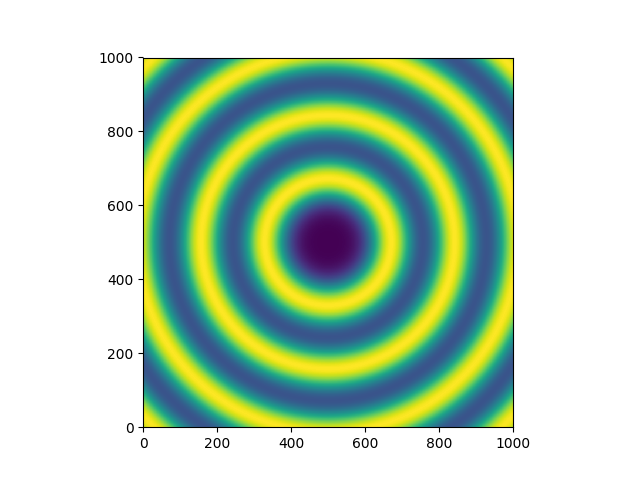

In [4]:
img = cal.fake_calibration_image(ai)
fig, ax = subplots()
ax.imshow(img, origin="lower")

## Translation orthogonal to the beam: poni1 and poni2
We will now set the first dimension (vertical) offset to the center of the detector: 100e-6 * 1000 / 2

In [5]:
p1 = 100e-6 * 1000 / 2
print("poni1:", p1)
ai.poni1 = p1
img = cal.fake_calibration_image(ai)
imshow(img, origin="lower")

poni1: 0.05


Let's do the same in the second dimensions: along the horizontal axis

In [6]:
p2 = 100e-6 * 1000 / 2
print("poni2:", p2)
ai.poni2 = p2
print(ai)
img = cal.fake_calibration_image(ai)
imshow(img, origin="lower")

poni2: 0.05
Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=500.000, y=500.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


The image is now properly centered. Let's investigate the sample-detector distance dimension.

For this we need to describe a detector which has a third dimension which will be offseted in the third dimension by half a meter.




<IPython.core.display.Javascript object>


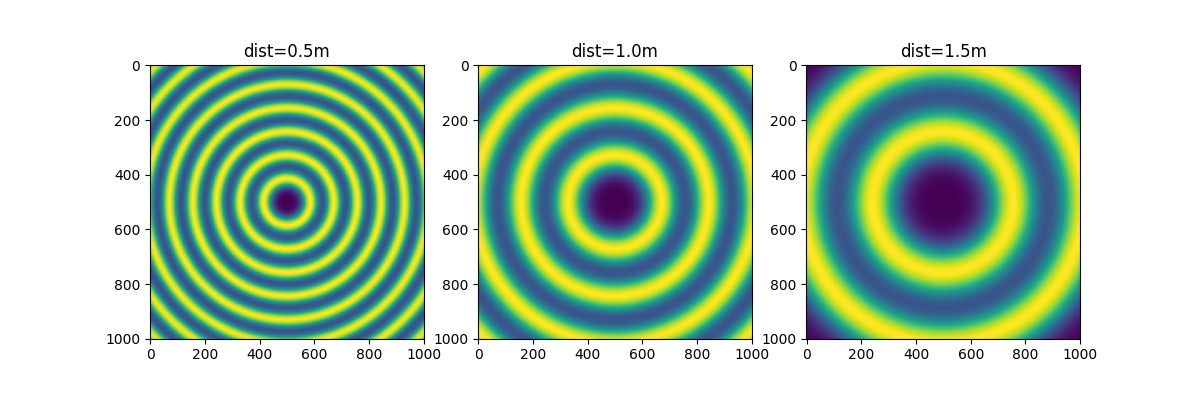

In [7]:
import copy 
fig, ax = subplots(1, 3, figsize=(12,4))
ref_10 = cal.fake_calibration_image(ai, W=1e-4)
ax[1].imshow((ref_10))

ai05 = copy.copy(ai)
ai05.dist = 0.5
ref_05 = cal.fake_calibration_image(ai05, W=1e-4)
ax[0].imshow((ref_05))
ai15 = copy.copy(ai)
ai15.dist = 1.5
ref_15 = cal.fake_calibration_image(ai15, W=1e-4)
ax[2].imshow((ref_15))

ax[0].set_title("dist=0.5m")
ax[1].set_title("dist=1.0m")
ax[2].set_title("dist=1.5m")

In [8]:
class ShiftedDetector(pyFAI.detectors.Detector):
    IS_FLAT = False  # this detector is flat
    IS_CONTIGUOUS = True  # No gaps: all pixels are adjacents, speeds-up calculation
    API_VERSION = "1.0"
    aliases = ["ShiftedDetector"]
    MAX_SHAPE=1000,1000
    def __init__(self, pixel1=100e-6, pixel2=100e-6, offset=0):
        pyFAI.detectors.Detector.__init__(self, pixel1=pixel1, pixel2=pixel2)
        self.d3_offset = offset
    def calc_cartesian_positions(self, d1=None, d2=None, center=True, use_cython=True):
        res = pyFAI.detectors.Detector.calc_cartesian_positions(self, d1=d1, d2=d2, center=center, use_cython=use_cython)
        return res[0], res[1], numpy.ones_like(res[1])*self.d3_offset

shiftdet = ShiftedDetector(offset=0.5)
print(shiftdet)
#print(sf.calc_cartesian_positions(center=False))

Detector ShiftedDetector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


Detector ShiftedDetector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=500.000, y=500.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


<IPython.core.display.Javascript object>


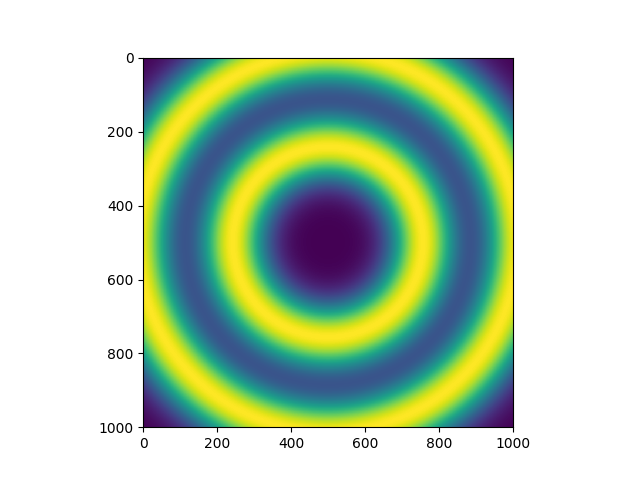

In [9]:
aish = pyFAI.AzimuthalIntegrator(dist=1, poni1=p1, poni2=p2, detector=shiftdet, wavelength=wl)
print(aish)
fig, ax = subplots()
shifted = cal.fake_calibration_image(aish, W=1e-4)
ax.imshow((shifted))

This image is the same as the one with dist=1.5m
The positive distance along the *d3* direction is equivalent to increase the distance. 
*d3* is in the same direction as the incoming beam.

After investigation of the three translations, we will now investigate the rotation along the different axes.

## Investigation on the rotations:

Any rotations of the detector apply after the 3 translations (*dist*, *poni1* and *poni2*)

The first axis is the vertical one and a rotation around it ellongates ellipses along the orthogonal axis:

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.200000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1020.339mm	Center: x=-1527.100, y=500.000 pix	Tilt=11.459 deg  tiltPlanRotation= 180.000 deg


<IPython.core.display.Javascript object>


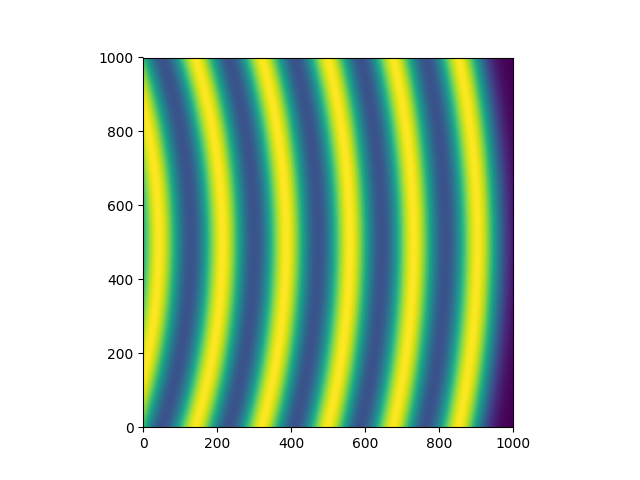

In [10]:
rotation = +0.2
ai.rot1 = rotation
print(ai)
img = cal.fake_calibration_image(ai)
fig, ax = subplots()
ax.imshow(img, origin="lower")

So a positive rot1 is equivalent to turning the detector to the right, around the sample position (where the observer is).

Let's consider now the rotation along the horizontal axis, rot2:

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.000000  rot2= 0.200000  rot3= 0.000000 rad
DirectBeamDist= 1020.339mm	Center: x=500.000, y=2527.100 pix	Tilt=11.459 deg  tiltPlanRotation= 90.000 deg


<IPython.core.display.Javascript object>


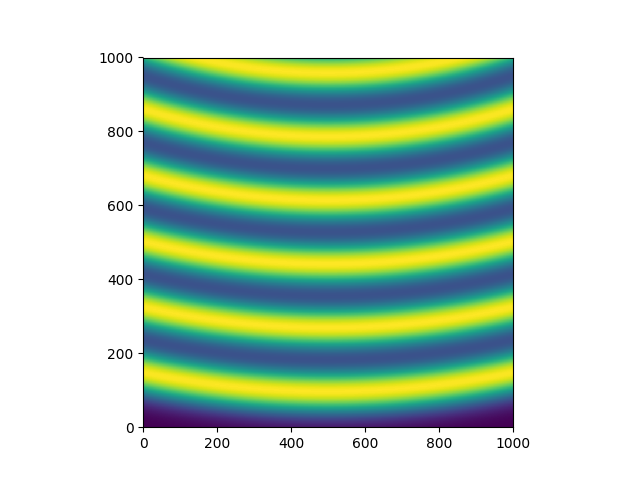

In [11]:
rotation = +0.2
ai.rot1 = 0
ai.rot2 = rotation
print(ai)
img = cal.fake_calibration_image(ai)

fig, ax = subplots()
ax.imshow(img, origin="lower")

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.200000  rot2= 0.200000  rot3= 0.000000 rad
DirectBeamDist= 1041.091mm	Center: x=-1527.100, y=2568.329 pix	Tilt=16.151 deg  tiltPlanRotation= 134.423 deg


<IPython.core.display.Javascript object>


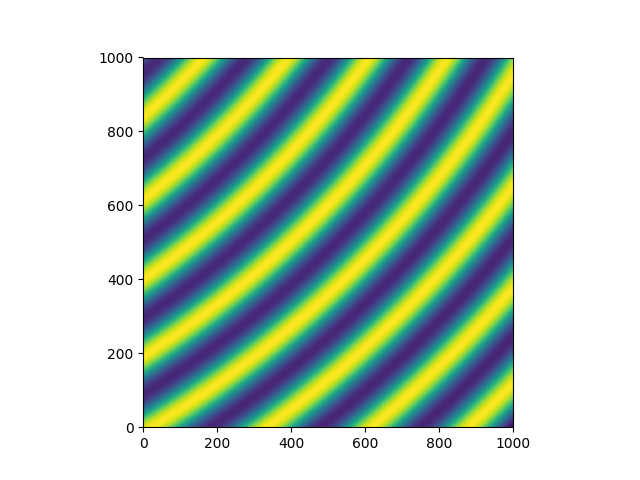

In [12]:
rotation = +0.2
ai.rot1 = rotation
ai.rot2 = rotation
ai.rot3 = 0
print(ai)
img = cal.fake_calibration_image(ai)

fig, ax = subplots()
ax.imshow(img, origin="lower")

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 5.000000e-02, 5.000000e-02m	rot1=0.200000  rot2= 0.200000  rot3= 0.200000 rad
DirectBeamDist= 1041.091mm	Center: x=-1527.100, y=2568.329 pix	Tilt=16.151 deg  tiltPlanRotation= 134.423 deg


<IPython.core.display.Javascript object>


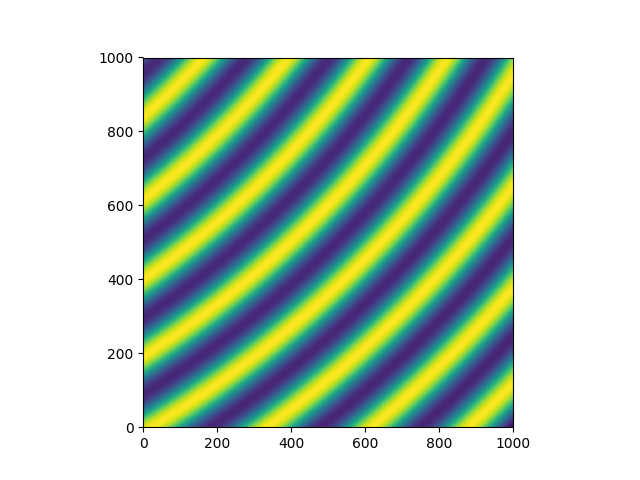

In [13]:
rotation = +0.2
import copy
ai2 = copy.copy(ai)
ai2.rot1 = rotation
ai2.rot2 = rotation
ai2.rot3 = rotation
print(ai2)
img2 = cal.fake_calibration_image(ai2)

fig, ax = subplots()
ax.imshow(img2, origin="lower")

If one considers the rotation along the incident beam, there is no visible effect on the image as the image is invariant along this transformation.

To actually see the effect of this third rotation one needs to perform the azimuthal integration and display the result with properly labeled axes.

<IPython.core.display.Javascript object>


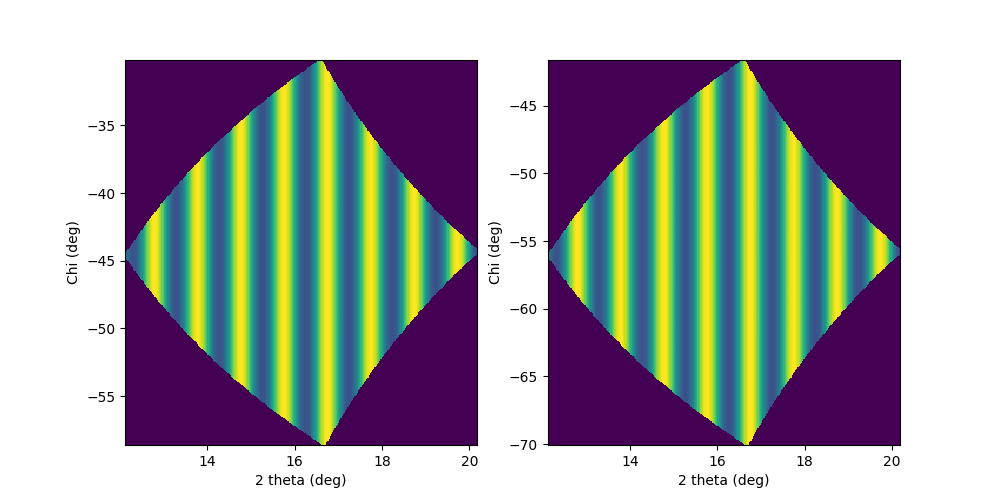

In [14]:
fig, ax = subplots(1,2,figsize=(10,5))

I, tth, chi = ai.integrate2d(img, 300, 360, unit="2th_deg")
ax[0].imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto")
ax[0].set_xlabel("2 theta (deg)")
ax[0].set_ylabel("Chi (deg)")

I, tth, chi = ai2.integrate2d(img2, 300, 360, unit="2th_deg")
ax[1].imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto")
ax[1].set_xlabel("2 theta (deg)")
ax[1].set_ylabel("Chi (deg)")

So the increasing *rot3* creates more negative azimuthal angles: it is like rotating the detector clockwise around the incident beam.

## Conclusion

All 3 translations and all 3 rotations can be summarized in the following figure: 

![PONI figure](../../../img/PONI.png "test")


It may appear strange to have (x_1, x_2, x_3) indirect indirect but this has been made in such a way chi, the azimuthal angle, is 0 along x_2 and 90_deg along x_1 (and not vice-versa).


In [15]:
print("Processing time: %.3fs"%(time.time()-start_time))

Processing time: 6.404s
